# Przewidywanie zwycięzcy rundy w grze Counter Strike: Global Offensive

## Dane

Zbiór danych składa się ze snapshotów rund z około 700 meczów z profesjonalnych turniejów rozgrywanych w 2019 i 2020 roku.

Snapshoty - czyli zestawienie pewnych stanów kluczowych elementów rozgrywki - były rejestrowane podczas gry co 20 sekund aż do rozstrzygnięcia danej rundy. Łączna liczba zapisanych snapshotów wynosi 122411. Część tych rekordów będzie traktowana jako
zbiór danych uczących, a pozostała część jako część danych testów. Każdy rekord traktowany jest jako pojedynczy, niezależny element do analizy danych.

## Czym jest klasyfikator MLP?

Perceptron wielowarstwowy (MLP) to model sztucznej sieci neuronowej ze sprzężeniem do przodu, który odwzorowuje zestawy danych wejściowych na zestaw odpowiednich danych wyjściowych.

MLP składa się z wielu warstw, a każda warstwa jest w pełni połączona z następną. Węzły warstw to neurony z nieliniowymi funkcjami aktywacji, z wyjątkiem węzłów warstwy wejściowej. Pomiędzy warstwą wejściową a wyjściową może znajdować się jedna lub więcej nieliniowych warstw ukrytych.

## Import bibliotek i danych

In [75]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [76]:
df = pd.read_csv('Data/csgo_round_snapshots.csv')

In [77]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [78]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [79]:
df.isnull().sum().sum()

0

In [80]:
df.shape

(122410, 97)

## Przeprocesowanie danych

W pierwszej koleności sprawdźmy liczność klas.

In [81]:
df['round_winner'].value_counts()

T     62406
CT    60004
Name: round_winner, dtype: int64

<AxesSubplot:xlabel='round_winner', ylabel='count'>

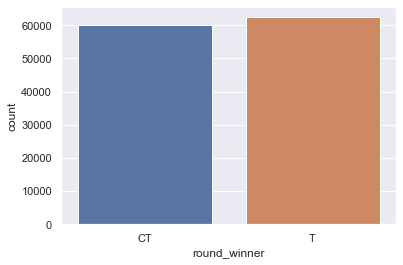

In [82]:
sns.set_theme(style="darkgrid")
sns.countplot(x='round_winner', data=df)

Następnie przekonwertujemy wszystkie kolumny na wartości liczbowe.

In [83]:
col = df.drop(df.select_dtypes(np.number), axis = 1).columns
col

Index(['map', 'bomb_planted', 'round_winner'], dtype='object')

In [84]:
lbl = LabelEncoder()
for value in col:
    df[value] = lbl.fit_transform(df[value])

In [85]:
df['bomb_planted'] = df['bomb_planted'].astype(np.int16)

In [86]:
cols = [f for f in df.columns if f not in ['round_winner']]

Dodatkowo każda wartość zostanie znormalizowana.

In [87]:
scaler = RobustScaler()

for value in cols:
    scaler = RobustScaler()
    df[value] = scaler.fit_transform(df[[value]])

Na koniec podzielimy dane na wektor danych oraz wektor wyników.

In [88]:
x = df.drop(['round_winner'], axis = 1)
y = df['round_winner']

In [89]:
len(cols)

96

Finalnie każdy rekord zawiera 96 atrybutów, które prezentują się w sposób przedstawiony poniżej.

In [90]:
x.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,0.715105,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,-1.291096,-1.136054,-0.112782,-0.191489,-0.5,-0.6,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
1,0.545726,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,0.078767,-0.115646,-0.368421,-0.395137,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
2,0.010000,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
3,-0.168575,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
4,0.714837,-0.714286,-0.857143,-0.666667,0.0,0.000000,0.000000,-0.633562,-1.136054,0.966165,0.218845,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0


### Wybór atrybutów

W pierwszej kolejności sprawdzimy, które atrybuty mają największy wpływ na klasy.

W tym celu wykorzystamy model *Random Forest Regressor*, który dopasowuje szereg klasyfikujących drzew decyzyjnych do różnych podpróbek zbioru danych i wykorzystuje uśrednianie w celu poprawy dokładności predykcyjnej i kontroli nadmiernego dopasowania.

In [91]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(x, y)

RandomForestRegressor(n_estimators=150)

Po stworzeniu i wyuczeniu modelu sortujemy tablice zawierającą informacje o tym, jak duży wpływ mają konkretne atrybuty w podejmowaniu decyzji.

In [92]:
indexes = rf.feature_importances_.argsort()

Wpływ poszczególnych atrybutów został przedstawiony na poniższym wykresie.

Text(0.5, 0, 'Feature Importance')

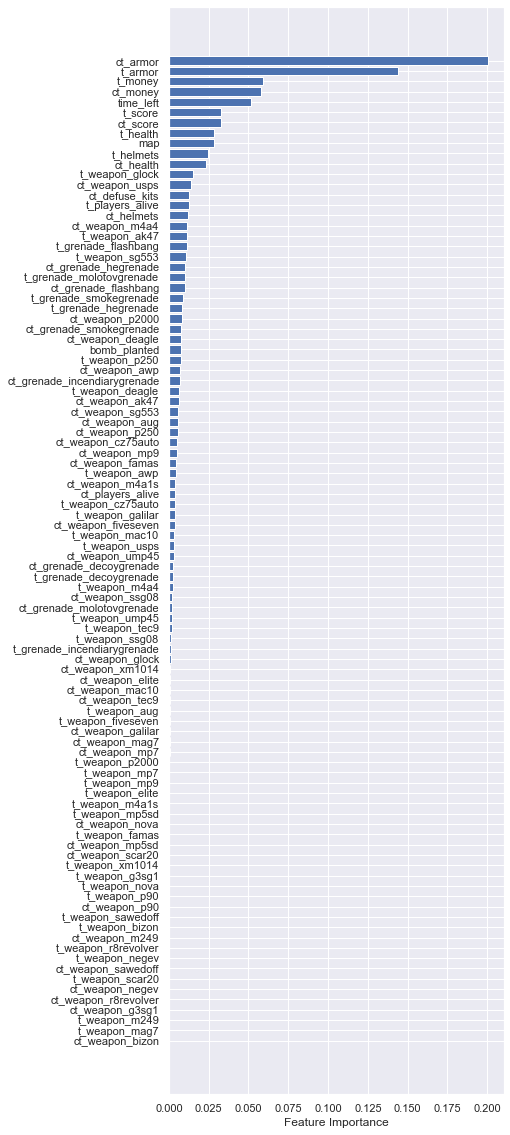

In [93]:
plt.figure(figsize=(6,20))
plt.barh(x.columns[indexes], rf.feature_importances_[indexes])
plt.xlabel("Feature Importance")

Następnie możemy odrzucić te atrybuty, które mają niski wpływ na podejmowanie decyzji lub nie mają żadnego. W tym celu wybraliśmy te atrybuty, dla których wartość parametru *feature_importance* jest większa od wartości 0,005.

In [94]:
importances = rf.feature_importances_[indexes]
indexes = indexes[np.argwhere(importances > 0.005)]
indexes = np.concatenate(indexes).ravel().tolist()
columns = x.columns[indexes]
x = x[columns]

W tym momencie możemy sprawdzić liczbę atrybutów pozostałych po selekcji.

In [95]:
x.shape

(122410, 39)

Mamy 38 atrybutów, które prezentują się jak w poniższej tabeli.

In [96]:
x.head()

,ct_weapon_mp9,ct_weapon_cz75auto,ct_weapon_p250,ct_weapon_aug,ct_weapon_sg553,ct_weapon_ak47,t_weapon_deagle,ct_grenade_incendiarygrenade,ct_weapon_awp,t_weapon_p250,bomb_planted,ct_weapon_deagle,ct_grenade_smokegrenade,ct_weapon_p2000,t_grenade_hegrenade,t_grenade_smokegrenade,ct_grenade_flashbang,t_grenade_molotovgrenade,ct_grenade_hegrenade,t_weapon_sg553,t_grenade_flashbang,t_weapon_ak47,ct_weapon_m4a4,ct_helmets,t_players_alive,ct_defuse_kits,ct_weapon_usps,t_weapon_glock,ct_health,t_helmets,map,t_health,ct_score,t_score,time_left,ct_money,t_money,t_armor,ct_armor
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,-0.333333,-0.5,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,-0.333333,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.857143,-0.857143,0.715105,-0.112782,-0.191489,-1.136054,-1.291096
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.333333,-0.333333,-0.5,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.857143,-0.857143,0.545726,-0.368421,-0.395137,-0.115646,0.078767
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.333333,-0.333333,-0.5,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,-1.0,0.000000,0.333333,0.000000,-0.726667,-0.6,-0.666667,-0.561798,-0.857143,-0.857143,0.010000,-0.357143,-0.404255,-0.455782,-0.284247
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,-0.333333,-0.333333,-0.5,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,-1.0,0.000000,0.333333,-0.333333,-0.726667,-0.6,-0.666667,-0.561798,-0.857143,-0.857143,-0.168575,-0.357143,-0.404255,-0.455782,-0.284247
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,-0.333333,-0.5,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.714286,-0.857143,0.714837,0.966165,0.218845,-1.136054,-0.633562


Mając już przetworzone dane, możemy wydzielić z nich zbiór treningowy oraz testowy.

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.1, random_state = 0)

In [98]:
x_train.shape

(110169, 39)

In [99]:
x_test.shape

(12241, 39)

Jak widać na podstawie powyższych wywołań, mamy 110169 rekordów w zbiorze treningowym oraz 12241 w zbiorze testowym. W tym momencie możemy rozpocząć inicjalizacje modelu.

### Definicja i inicjalizacja modelu

W celu inicjalizacji modelu zostanie wykorzystany klasyfikator MLP, zaimplementowany w bibliotece *scikit-learn* jako *MLPClassifier*.

*MLPClassifier* określa wielowarstwowy perceptron. W przeciwieństwie do innych algorytmów klasyfikacji, takich jak klasyfikator wektorów wspierających lub naiwny klasyfikator Bayesa, *MLPClassifier* przy wykonaniu zadania klasyfikacji opiera się na podstawowej sieci neuronowej.

Istotne cechy wielowarstwowego perceptronu MLP w bibliotece *scikit-learn*:
- w warstwie wyjściowej nie ma funkcji aktywacji,
- w przypadku scenariuszy regresji błąd kwadratowy jest funkcją straty, a entropia krzyżowa jest funkcją straty klasyfikacji,
- może pracować z regresją pojedynczych, jak i wielu wartości docelowych,
- w przeciwieństwie do innych popularnych pakietów, implementacja MLP w *scikit* nie obsługuje GPU.
- nie jest możliwe dostrojenie parametrów, takich jak różne funkcje aktywacji, inicjatory wagi itp. dla każdej warstwy.

In [100]:
nn_clf = MLPClassifier(verbose = True)

Opcja *verbose=True* powoduje, że na standardowe wyjście będą drukowane wiadomości o postępach w kolejnych iteracjach.

Następnie przechodzimy do dopasowania modelu do macierzy danych *x_train* i wyniku *y_train*.

In [101]:
nn_clf.fit(x_train, y_train)

Iteration 1, loss = 0.48001526
Iteration 2, loss = 0.45443920
Iteration 3, loss = 0.44855651
Iteration 4, loss = 0.44424559
Iteration 5, loss = 0.44119112
Iteration 6, loss = 0.43881870
Iteration 7, loss = 0.43602165
Iteration 8, loss = 0.43413346
Iteration 9, loss = 0.43238168
Iteration 10, loss = 0.43044811
Iteration 11, loss = 0.42913017
Iteration 12, loss = 0.42795988
Iteration 13, loss = 0.42631679
Iteration 14, loss = 0.42556749
Iteration 15, loss = 0.42417754
Iteration 16, loss = 0.42340622
Iteration 17, loss = 0.42236470
Iteration 18, loss = 0.42125027
Iteration 19, loss = 0.42059905
Iteration 20, loss = 0.41999418
Iteration 21, loss = 0.41908024
Iteration 22, loss = 0.41836787
Iteration 23, loss = 0.41730338
Iteration 24, loss = 0.41688252
Iteration 25, loss = 0.41585448
Iteration 26, loss = 0.41513754
Iteration 27, loss = 0.41442731
Iteration 28, loss = 0.41370405
Iteration 29, loss = 0.41292838
Iteration 30, loss = 0.41222901
Iteration 31, loss = 0.41179587
Iteration 32, los

C:\Users\adasi\AppData\Local\pypoetry\Cache\virtualenvs\csgo-round-prediction-GhoYBn2B-py3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(verbose=True)

W tym momencie możemy sprawdzić średnią trafność modelu na rozważanych danych testowych.

In [102]:
print(f'Model sieci neuronowej: {nn_clf.score(x_test, y_test)}')

Model sieci neuronowej: 0.7863736622824933


## Podział prac

1. ~~Wybór niezbędnych bibliotek - Jakub Michalak~~
1. ~~Walidacja i wydzielenie danych treningowych - Damian Opoka~~
1. ~~Analiza i przygotowanie danych - Damian Opoka~~
1. ~~Definicja modelu - Adam Ryl~~
1. Weryfikacja krzyżowa - Adam Ryl
1. Dostosowanie hiperparametrów - Jakub Michalak
1. Wygenerowanie wyników - Piotr Kryczka
1. Analiza wyników - Piotr Kryczka